In [ ]:
%load_ext rpy2.ipython
import numpy as np
import pandas as pd
from pkg.plot import Figure, Panel, SmartSVG, Text
from scipy.spatial.distance import squareform

from twins.data import load_dataset

In [ ]:
%%R
myPaths <- .libPaths()
myPaths <- c("/home/j1c/R/packages", myPaths)
.libPaths(myPaths)

suppressPackageStartupMessages(library(ComplexHeatmap))
suppressPackageStartupMessages(library(circlize))
suppressPackageStartupMessages(library(extrafont))
suppressPackageStartupMessages(library(svglite))

invisible(font_import())

In [268]:
subjects = [
    str(sub)
    for sub in pd.read_csv(
        "../../twins/data/subject_metadata/truncated_restricted_processed_valid_subjects.csv"
    ).Subject
]

df = pd.read_csv(
    "../../twins/data/subject_metadata/truncated_restricted_processed_valid_subjects.csv"
)

df = df.sort_values("Subject")
df.head()

# remove singletons
uniques, counts = np.unique(df.Family_ID, return_counts=True)

singletons = []

for unique, count in zip(uniques, counts):
    if count == 1:
        sub = df[df.Family_ID == unique].Subject.iloc[0]

        singletons.append(sub)

singleton_idx = df.Subject.isin(singletons).values

In [269]:
np.save("./average_graph", average_graph)
np.save("./maximum_diff", maximum_diff)

In [13]:
parc = "Desikan"

graphs = load_dataset(parcellation=parc, ptr=None)
graphs = {key: val for key, val in graphs.items() if key in subjects}

X = np.load(f"../../twins/notebooks/outs/1-connectome-distances/arrs/exact_{parc}.npy")
X = np.linalg.norm(X, axis=(1, 2))

average_graph = np.mean(list(graphs.values()), axis=0)
average_graph[average_graph < 1] = 0

maximum = X.max()
idx, _ = np.where(squareform(X) == maximum)

sub1 = df.iloc[idx[0]].Subject
sub2 = df.iloc[idx[1]].Subject
A1 = graphs[str(sub1)]
A2 = graphs[str(sub2)]

maximum_diff = np.abs(A1 - A2)

vmax = np.log10(np.max([maximum_diff, average_graph]))
vmin = 1

average_graph = np.log10(average_graph + 1)
maximum_diff = np.log10(maximum_diff + 1)

In [133]:
%%R -i average_graph -i maximum_diff

plotting.labels <- c()

for (i in 1:35){
    plotting.labels <- c(plotting.labels, "L")
}
for (i in 1:35){
    plotting.labels <- c(plotting.labels, "R")
}

vmax <- max(c(average_graph, maximum_diff))
# plotting.labels <- c(plotting.labels, tolower(plotting.labels))
plotting.labels <- factor(plotting.labels, levels = unique(plotting.labels))

# Make the heatmap
plot.heatmap <- function(matrix, name, save=FALSE, width=unit(1, "npc")) {
    ha = HeatmapAnnotation(
        foo = anno_block(
            gp = gpar(fill = 2:8, col = 0),
            labels = c("Left", "Right"),
            labels_gp = gpar(
                col = "white", 
                fontsize = 14,
                fontfamily = "DejaVu Sans"
                # fontface="bold"
            )
        ),
        height = unit(6, "mm")
    )
    ra = rowAnnotation(
        foo = anno_block(
            gp = gpar(fill = 2:8, col = 0),
            labels = c("Left", "Right"),
            labels_gp = gpar(
                col = "white", 
                fontsize = 14,
                fontfamily = "DejaVu Sans"
                # fontface="bold"
            )
        ),
        width = unit(6, "mm")
    )
    if (!isFALSE(save)){
        width <- 7
        height <- width
        svglite(paste0("./figures/", save, ".svg"), width=width,  height=height)
        # svg(paste0("./figures/", save, ".svg"))
    }
    ht <- Heatmap(
        matrix = matrix, 
        col = colorRamp2(c(0, vmax), c("white", "red")),
        border = TRUE, 
        rect_gp = gpar(lwd=0.0, col=0),
        name = "Edge Weight", 
        column_title = name,
        column_title_gp = gpar(fontsize = 25, fontfamily = "DejaVu Sans"),
        cluster_columns = FALSE, 
        cluster_column_slices = FALSE, 
        show_column_names = FALSE,
        cluster_rows = FALSE, 
        cluster_row_slices = FALSE, 
        show_row_names = FALSE, 
        row_title = NULL,
        column_split = plotting.labels, 
        row_split = plotting.labels,
        top_annotation = ha,
        left_annotation = ra,
        heatmap_width = width,
        heatmap_height= width,
        show_heatmap_legend = FALSE
    )
    draw(ht)
    if (!isFALSE(save)){
        dev.off()
    }
}

In [135]:
%%R
plot.heatmap(average_graph, "Average Graph", "3a-average")

plot.heatmap(maximum_diff, "Difference in Most Different Pair", "3b-difference")

png 
  2 


In [249]:
%%R

# Make legend
svglite(paste0("./figures/", "3-legend", ".svg"), height=3.1, width=0.65)

colorbar < -Legend(
    col_fun=colorRamp2(c(0, vmax), c("white", "red")),
    title="Log Edgeweight",
    legend_width=unit(1, "inches"),
    legend_height=unit(3, "inches"),
    direction="vertical",
    title_position="leftcenter-rot",
    title_gp=gpar(fontsize=14, fontfamily="DejaVu Sans"),
    labels_gp=gpar(fontsize=14, fontfamily="DejaVu Sans"),
)
pd = packLegend(colorbar, direction="horizontal")
draw(
    pd,
)

dev.off()

png 
  2 


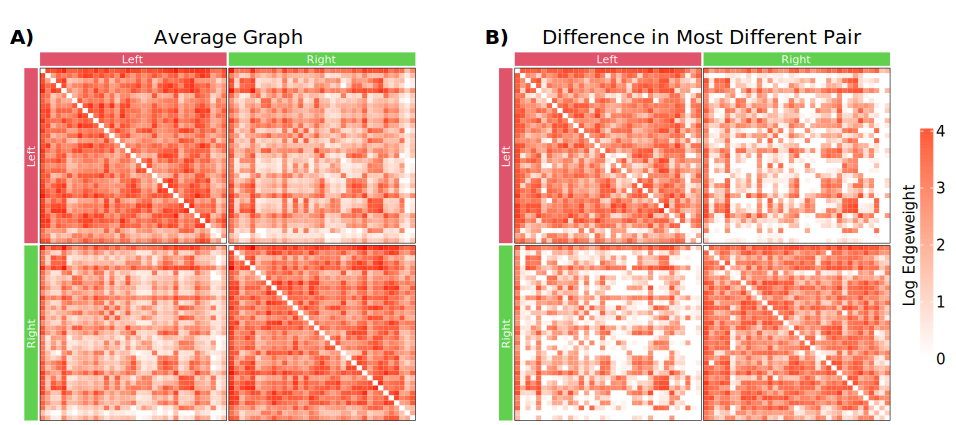

In [266]:
fontsize = 20

parta = SmartSVG("./figures/3a-average.svg")
parta.set_width(500)
parta.move(20, 25)
parta_panel = Panel(
    parta, Text("A)", 10, 44, size=fontsize, weight="bold", font="DejaVu Sans")
)

partb = SmartSVG("./figures/3b-difference.svg")
partb.set_width(500)
partb.move(20, 25)
partb_panel = Panel(
    partb, Text("B)", 10, 44, size=fontsize, weight="bold", font="DejaVu Sans")
)
partb_panel.move(parta.width * 0.95, 0)

legend = SmartSVG("./figures/3-legend.svg")
legend.set_height(300)
legend.move(0, 25)
legend.move((parta.width + partb.width) * 0.9, parta.height * 0.2)


fig = Figure(
    (parta.width + partb.width + legend.width) * 0.9,
    (parta.height) * 0.85,
    parta_panel,
    partb_panel,
    legend,
)

fig.save("./figures/3-composite.svg")
fig

In [267]:
import cairosvg

cairosvg.svg2pdf(url="./figures/3-composite.svg", write_to="./figures/3-composite.pdf")

## Using python


In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from graspologic.plot.plot import _process_graphs
from graspologic.plot.plot_matrix import _remove_shared_ax, draw_colors
from graspologic.simulations import sbm
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
from pkg.plot import Figure, Panel, SmartSVG, Text, heatmap

In [ ]:
X = np.load("./average_graph.npy")
Y = np.load("./maximum_diff.npy")

In [ ]:
hexes = [
    "#ffffff",
    "#fff5f0",
    "#fee0d2",
    "#fcbba1",
    "#fc9272",
    "#fb6a4a",
    "#ef3b2c",
    "#cb181d",
]
rgbs = [matplotlib.colors.hex2color(i) for i in hexes]

cmap = sns.blend_palette(rgbs, as_cmap=True)
cmap

In [ ]:
layout = [
    ["X", "Y", "cbar"],
]


fig, axes = plt.subplot_mosaic(
    layout, figsize=(12, 5), dpi=150, width_ratios=[1, 1, 0.05]
)

heatmaps = dict(X=X, Y=Y)
inner_hier_labels = ["Left"] * 35 + ["Right"] * 35
for key, data in heatmaps.items():
    if key == "cbar":
        continue

    heatmap_kwargs = dict(
        cmap=cmap,
        vmax=4.1,
        center=None,
        cbar=True,
        cbar_ax=axes["cbar"],
    )
    ax = axes[key]
    heatmap(
        data,
        ax,
        inner_hier_labels,
        heatmap_kwargs=heatmap_kwargs,
    )

    gap = 0.0035
    xloc = data.shape[0] // 2

    for i in range(xloc * 2):
        ax.axhline(i, c="w", lw=0.075)
        ax.axvline(i, c="w", lw=0.075)

axes["cbar"].set_ylabel(
    "Log Edge Weight",
)
axes["cbar"].tick_params(direction="in", length=4, width=1, color="w")

title_kwgs = dict(loc="left", fontsize=15, pad=25)

axes["X"].set_title("A) Average Connectome", **title_kwgs)
axes["Y"].set_title("B) Difference in Most Different Pair", **title_kwgs)

fig.savefig("./figures/3-data.svg", bbox_inches="tight")